In [1]:
#meta 10/11/2020 myTry Ch 4&5. Image Classification (multilabel) - MNIST full.

In [2]:

#hide
from fastbook import *

# Image Classification - MNIST
full dataset

## 0. Load Data

In [3]:
print(URLs.MNIST)

https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz


In [4]:
from fastai.vision.all import *
path = untar_data(URLs.MNIST)

In [6]:
Path.BASE_PATH = path

#see what's in our dataset -> 2 directories
path.ls()

(#2) [Path('testing'),Path('training')]

Files organization: train and test folders, then each digit in its own folder.

In [9]:
(path/"training").ls() #class fastcore.foundation.L

(#10) [Path('training/3'),Path('training/8'),Path('training/5'),Path('training/4'),Path('training/9'),Path('training/7'),Path('training/2'),Path('training/6'),Path('training/1'),Path('training/0')]

In [10]:
(path/"training/7").ls()

(#6265) [Path('training/7/11328.png'),Path('training/7/30538.png'),Path('training/7/36916.png'),Path('training/7/6986.png'),Path('training/7/981.png'),Path('training/7/50464.png'),Path('training/7/19370.png'),Path('training/7/18720.png'),Path('training/7/23309.png'),Path('training/7/9905.png')...]

In [14]:
#look at one image
fname = (path/"training/7").ls()[0]
Image.open(fname)

## 1. Preprocess Data
Get all files from training set and make them available as train and valid.

In [27]:
digits = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct = 0.2, seed=42),
                 get_y = parent_label, 
                 item_tfms=Resize(128))#,
                 #batch_tfms=aug_transforms(size=224, min_scale=0.75)

dls = digits.dataloaders(path/"training")

In [28]:
digits.__class__, dls.__class__

(fastai.data.block.DataBlock, fastai.data.core.DataLoaders)

#### Checking and Debugging a DataBlock

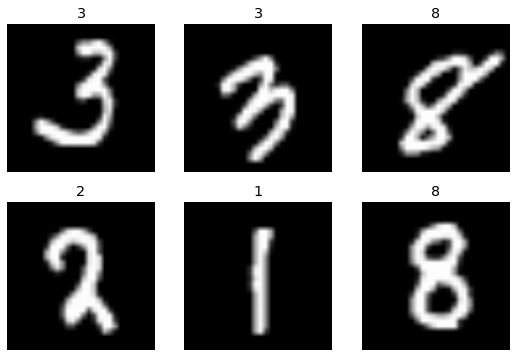

In [30]:
dls.show_batch(nrows=2, ncols=3)

## 2. Train model
### 2.1 Using fast.ai cnn learner, without pretrained model

In [50]:
learn = cnn_learner(dls, resnet18, pretrained=False, metrics=error_rate)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.168017,0.079864,0.019083,01:22


#### 2.1a Check Model Performance
on the validation set

In [51]:
x,y = dls.one_batch()

In [52]:
#preview actuals
y

TensorCategory([2, 1, 7, 3, 9, 2, 2, 3, 8, 4, 3, 7, 1, 1, 6, 8, 0, 3, 6, 6, 5, 6, 0, 8, 9, 7, 1, 4, 4, 4, 1, 7, 9, 3, 2, 3, 3, 8, 5, 5, 8, 7, 9, 6, 3, 1, 8, 9, 4, 6, 7, 8, 0, 0, 9, 7, 6, 2, 1, 6, 6, 7, 6, 0],
       device='cuda:0')

In [53]:
#preview first prediction
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([1.0954e-09, 2.2756e-07, 1.0000e+00, 1.8844e-09, 8.0767e-09, 7.3228e-12, 2.8577e-11, 9.6570e-08, 2.7813e-09, 1.2372e-10])

In [54]:
len(preds[0]),preds[0].sum()

(10, tensor(1.))

In [75]:
print("Metric: error rate")
learn.metrics[0].__class__ #fastai.learner.AvgMetric
learn.metrics[0].value

Metric: error rate


TensorCategory(0.0191)

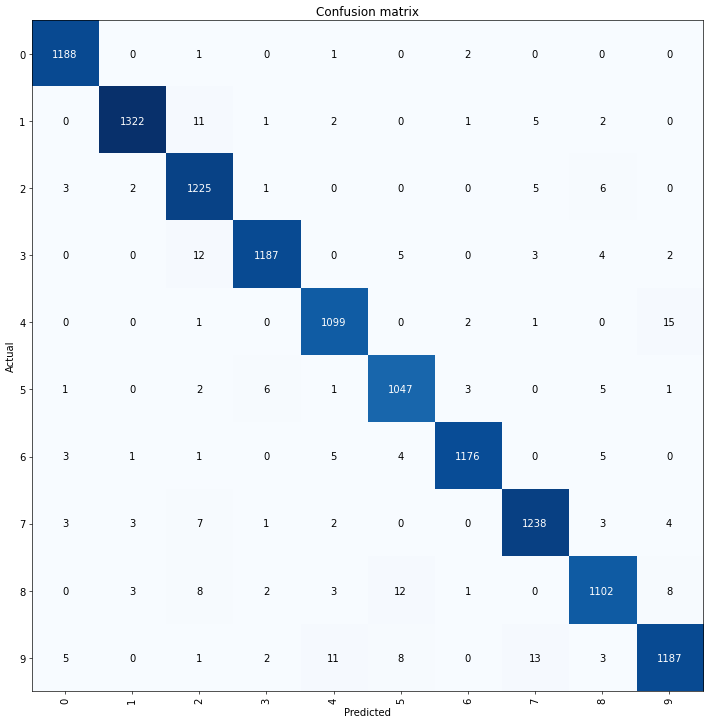

In [55]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [57]:
interp.most_confused(min_val=6)

[('4', '9', 15),
 ('9', '7', 13),
 ('3', '2', 12),
 ('8', '5', 12),
 ('1', '2', 11),
 ('9', '4', 11),
 ('8', '2', 8),
 ('8', '9', 8),
 ('9', '5', 8),
 ('7', '2', 7),
 ('2', '8', 6),
 ('5', '3', 6)]

### 2.2 Using fast.ai cnn learner, with pretrained model Resnet18

In [58]:
learn1 = cnn_learner(dls, resnet18, metrics=error_rate)
learn1.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.208516,0.122401,0.038000,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.056047,0.038061,0.009917,01:20
1,0.017041,0.022781,0.006417,01:20


#### 2.2a Check Model Performance
on the validation set

In [59]:
#preview predictions
preds1,_ = learn1.get_preds(dl=[(x,y)])
preds1[0]

tensor([8.3695e-10, 2.3573e-06, 1.0000e+00, 3.5137e-08, 1.4319e-09, 8.2035e-11, 1.1486e-08, 2.3266e-07, 1.4425e-10, 1.0431e-11])

In [60]:
len(preds1[0]),preds1[0].sum()

(10, tensor(1.))

In [76]:
print("Metric: error rate")
learn1.metrics[0].value

Metric: error rate


TensorCategory(0.0064)

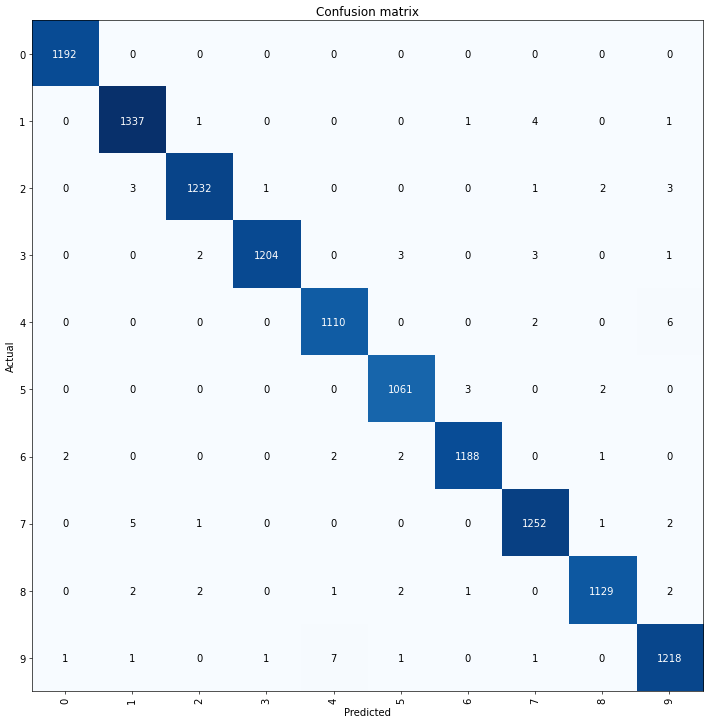

In [61]:
interp1 = ClassificationInterpretation.from_learner(learn1)
interp1.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [62]:
interp1.most_confused(min_val=6)

[('9', '4', 7), ('4', '9', 6)]

## 3. Evaluate Models on Testset
saved separately and not used for training and validation

In [74]:
print("Metric: error rate")
learn1.metrics[0].value

TensorCategory(0.0064)